In [1]:
# Query the RNA of interest using a prompt
# Only two kinds of prompts are possible: general and evolutionary. This is configured using the prompt_choice parameter 
# in configs/rna_rag.yaml. The general prompt (prompt_choice = 0) is used to ask a question about a given RNA, 
# while the evolutionary prompt (prompt_choice = 1) is used to generate a new RNA sequence. Both prompts can be 
# visualized and modified, if needed, in lib/RAG_Biomistral/rag_templates.py. 

import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from importlib import reload



In [2]:
# Read FASTA file for RNA query
from lib.fasta_utils import read_single_fasta, write_single_fasta

fasta_file = '../data/processed/RAG/rag_pipeline/trna_glycine.fasta'
FASTA_header, sequence = read_single_fasta(fasta_file)
print(FASTA_header, sequence)

URS0002910775 GCGGGAGUAACUCAGCUGGUAGAGUGCCGGCUUCCCAAGCCGGUUGUCGCGGGUUCGAAUCCCGUCUCCCGCUCCA


In [3]:
# CALCULATE 3D structure from sequence using DRfold2 model
# go to cd drfold2 and start container
# docker run --gpus all -it --name drfold_container -v .:/opt/drfold2 drfold_image bash
from lib.lib_drfold import fasta2pdb

pdb_file = fasta_file = '../data/processed/RAG/rag_pipeline/trna_glycine.pdb'
# Uncomment this line to generate a PDB file, or keep it commented to use an existing PDB file
# pdb_file = fasta2pdb(source_path = fasta_file) # generates a .pdb file in the same directory as the .fasta file

In [4]:
# Extract RNA properties from its 3D structure PDB file using DSSR
# Save part of the results to the PDBpromp dictionary for later use by RAG

import lib.lib_x3dna
reload(lib.lib_x3dna)
from lib.lib_x3dna import RnaProperties

fromPDB = RnaProperties(sequence=sequence, pdb_input=pdb_file)
PDBprompt = {}
PDBprompt["general_info"] = fromPDB.get_genInfo()
print("hairpins:", PDBprompt["general_info"]["hairpins"])
PDBprompt["helices_info"] = fromPDB.get_helicesInfo()

31 dict_keys(['num_pairs', 'pairs', 'num_multiplets', 'multiplets', 'num_helices', 'helices', 'num_stems', 'stems', 'num_coaxStacks', 'coaxStacks', 'num_stacks', 'stacks', 'nonStack', 'num_atom2bases', 'atom2bases', 'num_hairpins', 'hairpins', 'num_junctions', 'junctions', 'num_ssSegments', 'ssSegments', 'num_splayUnits', 'splayUnits', 'dbn', 'chains', 'num_nts', 'nts', 'num_hbonds', 'hbonds', 'refCoords', 'metadata'])
hairpins: ['CAGCUGGUAG', 'UUCCCAA', 'GUUCGAAUC']


In [5]:
# Prepare images for RAG input
from PIL import Image

pdbImage = fromPDB.get_pdbImage()
image_file = pdb_file.replace('.pdb', '.png')
plt.imsave(image_file, pdbImage, cmap='viridis')
rag_images = [Image.open(image_file).convert('RGB')]

In [6]:
# Calculate backfolded_rna
# Get RNA sequences from its 3D structure using RiboDiffusion model

import lib.lib_ribodiffusion
reload(lib.lib_ribodiffusion)
from lib.lib_ribodiffusion import Pdb2Fasta

pdb2fasta = Pdb2Fasta()
output = pdb2fasta.pdb2fasta(source_path = pdb_file, cond_scale=-1.)
output_sorted = sorted(output, key=lambda x: x[1], reverse=True) # sort by similarity to main_sequence
backfolded_rna_tuple = output_sorted[0] # choose the most similar one to the original RNA sequence
print("backfolded rna:", backfolded_rna_tuple[0])
print("Similarity to the initial RNA sequence:", backfolded_rna_tuple[1])


c:\Users\User\miniconda3\envs\rna_rag2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model size: 199.2MB


c:\Users\User\work\rna_rag\RiboDiffusion\utils.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state = torch.load(ckpt_dir, map_location=device)


backfolded rna: GGGGGGGUAACUCAGCUGGGAGAGUGCUGCCUUCGCAAGGCAGUGGUCAGCGGUUCGAAUCCGCUCUCCUCCUCCA
Similarity to the initial RNA sequence: 0.7894737124443054


In [7]:
# Instantiate RAG
from lib.RAG_Biomistral.RAG_Biomistral import RAG_Biomistral
reload(lib.RAG_Biomistral.RAG_Biomistral)  # Reload the module
from lib.RAG_Biomistral.RAG_Biomistral import RAG_Biomistral

rag = RAG_Biomistral()
#rag.preprocess(sequence=sequence, PDBprompt=PDBprompt, pdbImage=pdbImage)

CUDA is available True
CUDA version: 12.1
NVIDIA GeForce RTX 4060 Laptop GPU


The model: {'modelTXT_name': 'sentence-transformers/clip-ViT-B-32', 'modelIMAGE_name': 'sentence-transformers/clip-ViT-B-32'}
Image from: https://commons.wikimedia.org/w/index.php?curid=23636924


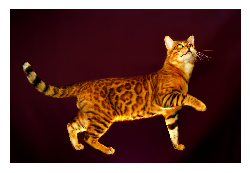

sentence-transformers


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Batches: 100%|██████████| 1/1 [00:00<00:00, 65.03it/s]


sentence-transformers


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]

text_embeddings: torch.Size([6, 512])
image_embedding: torch.Size([1, 512])
Score 0.179 for crocodile
Score 0.214 for dog
Score 0.250 for animal
Score 0.261 for cat
Score 0.320 for bengal cat
Score 0.370 for A striking Bengal cat with a golden-orange coat and bold rosette markings, walking with one paw raised and looking upward, illuminated against a deep maroon background.


In [8]:
# CHECK for image = text embeddings

# define image
image_path = "../data/raw/test_image/Bengal_cat_catcrest3.jpg"
# define description
long_description = "A striking Bengal cat with a golden-orange coat and bold rosette markings, walking with one paw " \
"raised and looking upward, illuminated against a deep maroon background."
descriptions = ["crocodile", "dog", "animal" , "cat", "bengal cat", long_description]
# compare
rag.text2image_test(image_path=image_path, descriptions=descriptions)

In [9]:

# Calculate embeddings for RNA books

# path2rnaBooks =  ["../data/raw/books/mattick.pdf",]
path2rnaBooks = [os.path.join(r, f) for r, _, files in os.walk("../data/raw/books") for f in files if f.lower().endswith(".pdf")]
if len(path2rnaBooks)==0:
    raise FileNotFoundError("No PDF books found. Please add PDF files to ../data/raw/books.")
# and save it here
path2bookEmbed = fasta_file.replace(fasta_file.split("/")[-1], "book_embeddings.pkl")

rag.calc_book_embeddings(path2rnaBooks=path2rnaBooks, path2bookEmbed=path2bookEmbed, save=True)
# Load LLM
rag.preprocess() 

Extracting book...
Book 1 contains 1540 pages
------------------------------
1540 chunks with 200 words each
sentence-transformers


Batches: 100%|██████████| 49/49 [00:01<00:00, 26.28it/s]


Building vector store...
Loading LLM...


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


cuda:0


In [10]:

answer = rag.process(main_sequence=sequence, backfolded_rna_tuple=backfolded_rna_tuple, 
            PDBprompt=PDBprompt, rag_images=rag_images)

c:\Users\User\work\rna_rag\lib\RAG_Biomistral\RAG_Biomistral.py:304: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), autocast():
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Please wait for LLM answer ...


c:\Users\User\miniconda3\envs\rna_rag2\Lib\site-packages\bitsandbytes\autograd\_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
c:\Users\User\miniconda3\envs\rna_rag2\Lib\site-packages\bitsandbytes\autograd\_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



    You are an expert in the origins of life and RNA structural evolution.

    **Task:** Propose a slightly shorter ancestral RNA sequence using both the current and reconstructed RNA sequences (76 nucleotides each). 

    **Current RNA sequence:**  
    GCGGGAGUAACUCAGCUGGUAGAGUGCCGGCUUCCCAAGCCGGUUGUCGCGGGUUCGAAUCCCGUCUCCCGCUCCA

**Hairpins of the current RNA sequence:**
CAGCUGGUAG, UUCCCAA, GUUCGAAUC

    **Reconstructed sequence from 3D structure of the current RNA sequence:**  
    GGGGGGGUAACUCAGCUGGGAGAGUGCUGCCUUCGCAAGGCAGUGGUCAGCGGUUCGAAUCCGCUCUCCUCCUCCA  
    (Sequence identity: 78.9%)

    **Requirements for the proposed ancestral RNA sequence:**  
    - Nucleotide changes must not exceed approximately 1% of the total nucleotides in the ancestral RNA sequence, with respect to the current RNA sequence.
    - Length of the proposed ancestral RNA sequence must be between 66 and 75 nucleotides.  

    **Output format:**  
    Return the proposed ancestral RNA sequence in upperca

In [11]:
print(answer)


    You are an expert in the origins of life and RNA structural evolution.

    **Task:** Propose a slightly shorter ancestral RNA sequence using both the current and reconstructed RNA sequences (76 nucleotides each). 

    **Current RNA sequence:**  
    GCGGGAGUAACUCAGCUGGUAGAGUGCCGGCUUCCCAAGCCGGUUGUCGCGGGUUCGAAUCCCGUCUCCCGCUCCA

**Hairpins of the current RNA sequence:**
CAGCUGGUAG, UUCCCAA, GUUCGAAUC

    **Reconstructed sequence from 3D structure of the current RNA sequence:**  
    GGGGGGGUAACUCAGCUGGGAGAGUGCUGCCUUCGCAAGGCAGUGGUCAGCGGUUCGAAUCCGCUCUCCUCCUCCA  
    (Sequence identity: 78.9%)

    **Requirements for the proposed ancestral RNA sequence:**  
    - Nucleotide changes must not exceed approximately 1% of the total nucleotides in the ancestral RNA sequence, with respect to the current RNA sequence.
    - Length of the proposed ancestral RNA sequence must be between 66 and 75 nucleotides.  

    **Output format:**  
    Return the proposed ancestral RNA sequence in upperca

In [12]:
# Compare two RNA sequences

from Bio.Align import PairwiseAligner

# Example RNA sequences
rna1 = sequence 
rna2 = answer.split("\n")[-1].strip().split(" ")[-1].replace('"', '').replace(':', '')



# Create and Configure the Aligner
aligner = PairwiseAligner()

# Optional: adjust scoring
aligner.match_score = 2
aligner.mismatch_score = -1
aligner.open_gap_score = -2
aligner.extend_gap_score = -0.5

# Run the Alignment
alignments = aligner.align(rna1, rna2)

# Print the Best Alignment
best_alignment = alignments[0]
print(type(best_alignment))
print(best_alignment)
print(f"Score: {best_alignment.score}")


<class 'Bio.Align.Alignment'>
target            0 GCGGGAGUAACUCAGCUGGUAGAGUGCCGGCUUCCCAAGCCGGUUGUC-GCGGGUUCGAA
                  0 |.|||.|||||||||||||.|||||||.|.||||.||||.|.||.|||-||-||||||||
query             0 GGGGGGGUAACUCAGCUGGGAGAGUGCUGCCUUCGCAAGGCAGUGGUCAGC-GGUUCGAA

target           59 UCCCGUCUCCCGCUCCA 76
                 60 |||..|||||..||||| 77
query            59 UCCGCUCUCCUCCUCCA 76

Score: 107.0
